# Capella Working

This notebook will be used to plot the retrieved capella SAR timesteps and investigate the response

In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
import ipyleaflet
import numpy as np
import pystac
import pystac_client
import planetary_computer
import requests
import rich.table
import xarray as xr 
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import pandas as pd
import os
import datetime as dt
from IPython.display import Image

/tmp/ipykernel_371/3050513954.py:11: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter
/tmp/ipykernel_371/3050513954.py:12: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance


In [2]:
# Import the TIF files from folder
Capture_1 = gdal.Open(r'Capella_data/CAPELLA_Clip1_C06_GEO_HH_20220729.tif') #2022/07/29
Capture_2 = gdal.Open(r'Capella_data/CAPELLA_Clip2_C03_GEO_HH_20220729.tif') #2022/07/29
Capture_3 = gdal.Open(r'Capella_data/CAPELLA_Clip3_C0_GEO_HH_20220731.tif') #2022/07/31
Capture_4 = gdal.Open(r'Capella_data/CAPELLA_Clip4_C05_GEO_HH_20220802.tif') #2022/08/02
Capture_5 = gdal.Open(r'Capella_data/CAPELLA_Clip5_C06_GEO_HH_20220804.tif') #2022/08/04
Capture_6 = gdal.Open(r'Capella_data/CAPELLA_Clip6_C06_GEO_HH_20220806.tif') #2022/08/06
Capture_7 = gdal.Open(r'Capella_data/CAPELLA_Clip7_C03_GEO_HH_20220806.tif') #2022/08/06

In [3]:
print(Capture_1.RasterCount)

1


In [4]:
C1 = Capture_1.GetRasterBand(1).ReadAsArray()
C2 = Capture_2.GetRasterBand(1).ReadAsArray()
C3 = Capture_3.GetRasterBand(1).ReadAsArray()
C4 = Capture_4.GetRasterBand(1).ReadAsArray()
C5 = Capture_5.GetRasterBand(1).ReadAsArray()
C6 = Capture_6.GetRasterBand(1).ReadAsArray()
C7 = Capture_7.GetRasterBand(1).ReadAsArray()

In [ ]:
f = plt.figure()
plt.imshow(C1)
plt.show()

In [5]:
# Removing zero values in the array
C1 = C1[C1 != 0]
C2 = C2[C2 != 0]
C3 = C3[C3 != 0]
C4 = C4[C4 != 0]
C5 = C5[C5 != 0]
C6 = C6[C6 != 0]
C7 = C7[C7 != 0]

In [6]:
def db_scale(x):
    return 10 * np.log10(x)

In [7]:
# Converting to Decibel (dB) scale
C1_dB = db_scale(C1)
C2_dB = db_scale(C2)
C3_dB = db_scale(C3)
C4_dB = db_scale(C4)
C5_dB = db_scale(C5)
C6_dB = db_scale(C6)
C7_dB = db_scale(C7)

<function matplotlib.pyplot.show(close=None, block=None)>

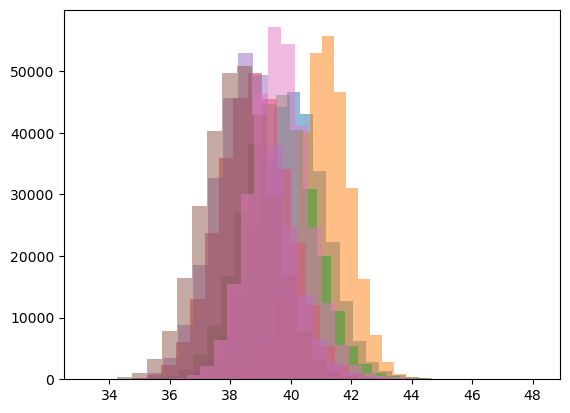

In [8]:
# Plot Histogram to check data is in dB.
_ = plt.hist(C1_dB, bins=30,alpha=0.5)  # arguments are passed to np.histogram
_ = plt.hist(C2_dB, bins=30,alpha=0.5)
_ = plt.hist(C3_dB, bins=30,alpha=0.5)
_ = plt.hist(C4_dB, bins=30,alpha=0.5)
_ = plt.hist(C5_dB, bins=30,alpha=0.5)
_ = plt.hist(C6_dB, bins=30,alpha=0.5)
_ = plt.hist(C7_dB, bins=30,alpha=0.5)
plt.show

In [9]:
# Calculate standard deviation of each image
C1_std = C1_dB.std()
C2_std = C2_dB.std()
C3_std = C3_dB.std()
C4_std = C4_dB.std()
C5_std = C5_dB.std()
C6_std = C6_dB.std()
C7_std = C7_dB.std()

In [10]:
# Calculate mean of each image
C1_mean = C1_dB.mean()
C2_mean = C2_dB.mean()
C3_mean = C3_dB.mean()
C4_mean = C4_dB.mean()
C5_mean = C5_dB.mean()
C6_mean = C6_dB.mean()
C7_mean = C7_dB.mean()

In [27]:
# assign data of lists.  
data = {'Capture': ['C1', 'C3', 'C4','C5','C6'], 
        'Mean':[C1_mean,C3_mean,C4_mean,C5_mean,C6_mean],
        'STD':[C1_std,C3_std,C4_std,C5_std,C6_std],
        'Time': ['2022-07-29', '2022-07-31', '2022-08-02','2022-08-04','2022-08-06']}  

In [31]:
data

{'Capture': ['C1', 'C3', 'C4', 'C5', 'C6'],
 'Mean': [40.06198, 39.598423, 38.805336, 38.657997, 38.248627],
 'STD': [1.1316776, 1.1895747, 1.1657083, 1.1651001, 1.1710061],
 'Time': ['2022-07-29',
  '2022-07-31',
  '2022-08-02',
  '2022-08-04',
  '2022-08-06']}

In [32]:
data_df = pd.DataFrame.from_dict(data, orient = 'columns')
data_df["Mean"] = pd.to_numeric(data_df["Mean"])
data_df["STD"] = pd.to_numeric(data_df["STD"])
data_df["Time"] = pd.to_datetime(data_df["Time"])    
data_df.dtypes

Capture            object
Mean              float32
STD               float32
Time       datetime64[ns]
dtype: object

Plot: 


Text(0.5, 1.0, 'Capella HH signal')

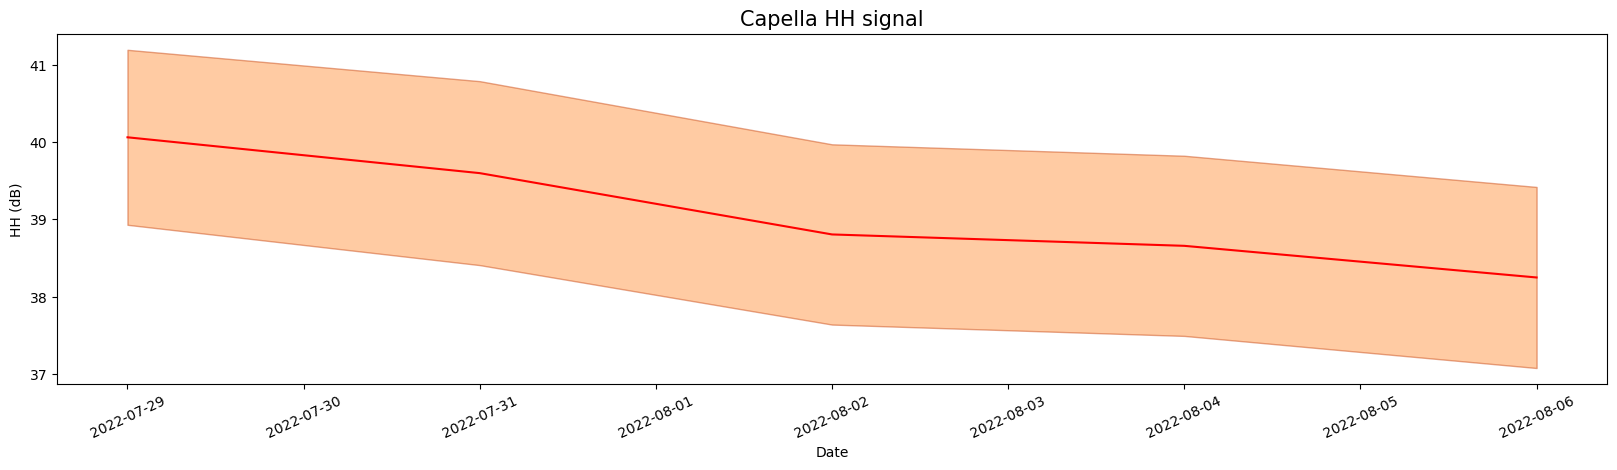

In [34]:
x = data_df['Time']
y = data_df['Mean']
STD = data_df['STD']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print("Plot: ")
plt.subplot(211)
line1, = plt.plot(x, y,color = 'r', linestyle = 'solid',label = "Capella")  
plt.fill_between(x, y-STD, y+STD, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xticks(rotation = 25)
plt.xlabel('Date')
plt.ylabel('HH (dB)')
plt.title('Capella HH signal', fontsize = 15)